In [24]:
# torch 1.13.0a0+gitb1dde16
# torchvision 0.14.1a0+5e8e2f1
# pillow 9.0.0
# pandas 1.3.5
# numpy 1.24.3
# tqdm 4.63.0
# intel_extension_for_pytorch 1.13.10+xpu
# opencv-python 4.2.0.32 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models

from PIL import Image
import pandas as pd

import numpy as np
import random

from tqdm import tqdm
import intel_extension_for_pytorch as ipex
import cv2

In [25]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False

# 使用vgg网络模型
modellr=1e-5
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[3].in_features
vgg16.classifier[3] = nn.Linear(num_features, 2048)
in_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(in_features, 2048)
num_features = vgg16.classifier[6].out_features
vgg16.classifier[6] = nn.Linear(num_features, 7)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(vgg16.parameters(), lr=modellr, momentum=0.9)
optimizer = torch.optim.Adam(vgg16.parameters(), lr = modellr)
EPOCHS=5
vgg16.train()
for i in range(0,5):
    freeze(vgg16.features[i])
vgg16.train()
vgg16,optimizer = ipex.optimize(vgg16,optimizer=optimizer)

In [26]:
# 预处理数据
transformer = transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5])  # 归一化
])
transformer1 = transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=1)
])
transformer2 = transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=1)
])
transformer3 = transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ColorJitter(contrast=0.1)
])
transformer4 = transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ColorJitter(contrast=0.9)
])

# 高斯噪声
def add_gaussian_noise(image):
    mean = 0
    std_dev = 10
    noise = np.random.normal(mean, std_dev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

# 椒盐噪声
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noise = np.zeros(image.shape, dtype=np.uint8)
    salt_locations = np.random.rand(*image.shape) < salt_prob
    pepper_locations = np.random.rand(*image.shape) < pepper_prob
    noise[salt_locations] = 255
    noise[pepper_locations] = 0
    noisy_image = cv2.add(image, noise)
    return noisy_image

data = pd.read_csv(r'./data2.txt',sep='\t',header=None,names=None)
train_images_tensor = []
test_images_tensor = []
train_labels_tensor = []
test_labels_tensor = []
name0 = []
name1 = []
name2 = []
for i in data.iloc[:,0]:
    file_name = i.split(' ')[0]
    label = i.split(' ')[1]
    if label=='1':
        name1.append(file_name)
    elif label=='0':
        name0.append(file_name)
    else:
        name2.append(file_name)
random.shuffle(name0)
random.shuffle(name1)
random.shuffle(name2)
image_list = [name0,name1,name2]
toPIL = transforms.ToPILImage()
for i in range(len(image_list)):
    for j in range(len(image_list[i])):
#         image = Image.open(r'./defect_product/'+image_list[i][j]).convert('L')
        image = Image.open(r'./defect_product/'+image_list[i][j])
        image1 = cv2.imread(r'./defect_product/'+image_list[i][j])
        if j+1<=len(image_list[i])*0.8:
            tensor = transformer(image).type(torch.float32)
            tensor1 = transformer1(image).type(torch.float32)
            tensor2 = transformer2(image).type(torch.float32)
            tensor3 = transformer3(image).type(torch.float32)
            tensor4 = transformer4(image).type(torch.float32)
            tensor5 = transformer(Image.fromarray(add_gaussian_noise(image1))).type(torch.float32)
            tensor6 = transformer(Image.fromarray(add_salt_and_pepper_noise(image1,salt_prob=0.05,pepper_prob=0.05))).type(torch.float32)
            train_images_tensor.append(tensor)
            train_images_tensor.append(tensor1)
            train_images_tensor.append(tensor2)
            train_images_tensor.append(tensor3)
            train_images_tensor.append(tensor4)
            train_images_tensor.append(tensor5)
            train_images_tensor.append(tensor6)
            label_tensor = torch.tensor(i)
            for l in range(7):
                train_labels_tensor.append(label_tensor)
        else:
            tensor = transformer(image).type(torch.float32)
            tensor1 = transformer1(image).type(torch.float32)
            tensor2 = transformer2(image).type(torch.float32)
            tensor3 = transformer3(image).type(torch.float32)
            tensor4 = transformer4(image).type(torch.float32)
            tensor5 = transformer(Image.fromarray(add_gaussian_noise(image1))).type(torch.float32)
            tensor6 = transformer(Image.fromarray(add_salt_and_pepper_noise(image1,salt_prob=0.05,pepper_prob=0.05))).type(torch.float32)
            test_images_tensor.append(tensor)
            test_images_tensor.append(tensor1)
            test_images_tensor.append(tensor2)
            test_images_tensor.append(tensor3)
            test_images_tensor.append(tensor4)
            test_images_tensor.append(tensor5)
            test_images_tensor.append(tensor6)
            label_tensor = torch.tensor(i)
            for l in range(7):
                test_labels_tensor.append(label_tensor)
torch.save(train_images_tensor, 'train_images_tensor2.pt')
torch.save(test_images_tensor, 'test_images_tensor2.pt')
torch.save(train_labels_tensor, 'train_labels_tensor2.pt')
torch.save(test_labels_tensor, 'test_labels_tensor2.pt')

In [27]:
# 加载tensor文件
train_images_tensor = torch.load('./train_images_tensor2.pt')
test_images_tensor = torch.load('./test_images_tensor2.pt')
train_labels_tensor = torch.load('./train_labels_tensor2.pt')
test_labels_tensor = torch.load('./test_labels_tensor2.pt')
train_datas_tensor = torch.stack(train_images_tensor)
train_labels_tensor = torch.stack(train_labels_tensor)
test_datas_tensor = torch.stack(test_images_tensor)
test_labels_tensor = torch.stack(test_labels_tensor)
train_dataset = TensorDataset(train_datas_tensor,train_labels_tensor)
train_dataloader = DataLoader(train_dataset,batch_size=8,shuffle=True)
test_dataset = TensorDataset(test_datas_tensor,test_labels_tensor)
test_dataloader = DataLoader(test_dataset,batch_size=8,shuffle=True)

In [28]:
for epoch in range(1,EPOCHS+1):
    running_loss = 0.0
    num_images = 0
    loop = tqdm(enumerate(train_dataloader,0))
    for step,data in loop:
        labels,inputs = data[1],data[0]
#         labels,inputs = data[1].to(device),data[0].to(device)
        optimizer.zero_grad()
        
        outputs = vgg16(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        num_images +=inputs.size(0)
        running_loss += loss.item()
        loop.set_description(f'Epoch [{epoch}/{EPOCHS}]')
        loop.set_postfix(loss=running_loss/(step+1))
print('Finish!!!')

Epoch [1/5]: : 81it [01:36,  1.19s/it, loss=0.763]
Epoch [2/5]: : 81it [01:35,  1.18s/it, loss=0.251]
Epoch [3/5]: : 81it [01:37,  1.21s/it, loss=0.111] 
Epoch [4/5]: : 81it [01:35,  1.18s/it, loss=0.0559]
Epoch [5/5]: : 81it [01:37,  1.21s/it, loss=0.0293]

Finish!!!


In [29]:
correct = 0
total = 0 
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0],data[1]
#         images, labels = data[0].to(device),data[1].to(device)
        outputs = vgg16(images)
        _,predicted = torch.max(outputs.data,1)
#         print(predicted,labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test set: {100*correct/total:.2f}%')
# print(f'correct:'+str(correct))
# print(f'total:'+str(total))
correct = 0
total = 0 
with torch.no_grad():
    for data in train_dataloader:
        images, labels = data[0],data[1]
#         images, labels = data[0].to(device),data[1].to(device)
        outputs = vgg16(images)
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on train set: {100*correct/total:.2f}%')

Accuracy on test set: 85.71%
Accuracy on train set: 99.07%


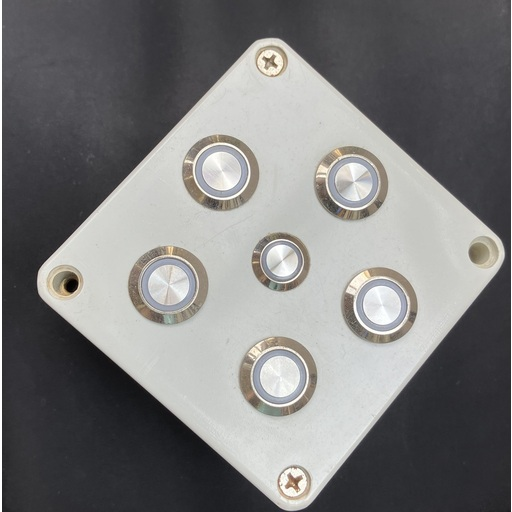

Predicted label: 2
产品不合格


In [30]:
# inference
transformer = transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
image = Image.open(r'./defect_product/119.JPG')
image.show()
tensor = transformer(image).type(torch.float32).reshape(1,3,224,224)
with torch.no_grad():
    outputs = vgg16(tensor)
    _,predicted = torch.max(outputs.data,1)
    print('Predicted label:',predicted.item())
    if predicted.item()==0:
        print('产品合格')
    elif predicted.item()==1:
        print('图片不完整，无法判断')
    else:
        print('产品不合格')

In [31]:
torch.save(vgg16.state_dict(),'./resnet_model_3.pth')
print("Model saved successfully!")

Model saved successfully!
